In [32]:
# Goal of the project is to apply ML to real data

# Step 1: just plot the data
# Step 2: which task? Supervised Learning!
# Step 3: train and test a few methods

# Comments on different algorithms, expenses, difficulties, findings?
# Hint: start with simple classification  (SoftMax)

In [33]:
# Specific project:
# Fundamental (scientific) question: why and how are we here?
# Secondary related question: how 100b galaxies formed and evolved?
# To answer we can start by classifying them!

In [34]:
# Specific goal:
# analyze JPG images and perform automated classification

In [35]:
# Data description:


# images_training: JPG images of 61578 galaxies. Files are named according to their GalaxyId.

# solutions_training: Probability distributions for the classifications for each of the training images.

# images_test: JPG images of 79975 galaxies. Files are name according to their GalaxyId. 
# You will provide probabilities for each of these images. 

# I think I just need the first two data sets 
# because the images_test are meant for the challange and have no labels

# Human labelling is done with a set of questions that divide the galaxies into types and sub-types.
# For each of them, after the labelling, it is possible to assign a probability.
# The labels for each galaxy are therefore probability distributions over all the sub-types!
# The data points instead are arrays of pixels composing images.

In [36]:
# Step 1: Loading and Plotting the Data

In [37]:
# Let's have a look at one of the galaxies... aka: how to load and visualize a jpg image with python

In [38]:
import skimage
from skimage import data
filename = 'images_training_rev1/100561.jpg' #first try just picking one...
from skimage import io
galaxy = io.imread(filename)

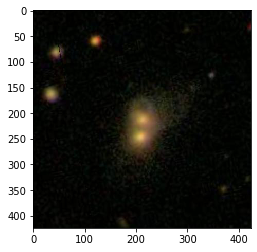

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(galaxy) #...and plot it!
plt.savefig("galaxy.pdf")

In [40]:
# Loading the data

# What are the GalaxyIDs? I can read them from the first column of the training_solutions file

import numpy as np
import os
import csv

# I read the file and create the list of IDs as well as the list of labels
with open("training_solutions_rev1.csv", 'r') as f: 
    reader = csv.reader(f, delimiter=",")
    train_ids = []
    y = []
    for k, line in enumerate(reader):
        if k == 0: continue # skip header
        train_ids.append(int(line[0]))
        y.append(line[1:])
        
train_ids = np.array(train_ids) # I save the IDs in this numpy array
my_train_ids = train_ids[0:800] # I want to work with less training data for computational cost reasons
my_valid_ids = train_ids[800:900] # galaxies IDs for my validation test (to chooose between my models)
my_test_ids = train_ids[900:1000] # These I choose to be the galaxies IDs for my final-test

# same split for the labels
y = np.asarray(y, dtype=float)  #change type of elements from string to float!
y_train = y[0:800]
y_valid = y[800:900]
y_test = y[900:1000]

# same split for the data points
x_train = []
x_valid = []
x_test = []
for ID in my_train_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_train.append(io.imread(filename))
for ID in my_valid_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_valid.append(io.imread(filename))
for ID in my_test_ids:
    filename = 'images_training_rev1/' + str(ID) + '.jpg'
    x_test.append(io.imread(filename))
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

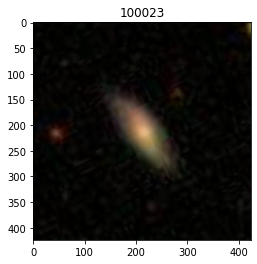

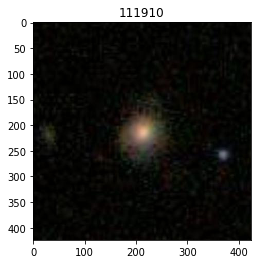

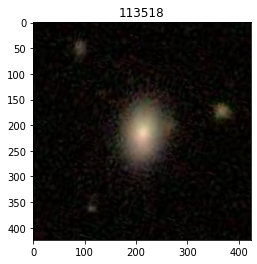

In [41]:
# Plotting two data points with their ID and label
# One from the training set...
plt.imshow(x_train[1]) 
plt.title(my_train_ids[1])
plt.show()

# ...one from the validation test...
plt.imshow(x_valid[2]) 
plt.title(my_valid_ids[2])
plt.show()

# ...and one from the testing set
plt.imshow(x_test[3]) 
plt.title(my_test_ids[3])
plt.show()



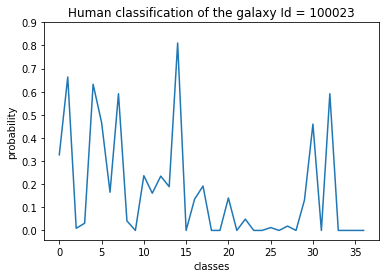

In [49]:
#Plotting the human labels, i.e. probabilities distributions according to the decision tree (the sum is not 1!)
index = 1
plt.plot(np.arange(37), y_train[index])
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('probability')
plt.xlabel('classes')
plt.title('Human classification of the galaxy Id = ' + str(my_train_ids[1]))
plt.savefig('Human labels.pdf')

In [42]:
# Each data point is an image of 424x424 pixels, 
# where each pixel is a set of 3 numbers giving the RGB intensities

x_train = np.asarray(x_train, dtype=float)
x_valid = np.asarray(x_valid, dtype=float)
x_test = np.asarray(x_test, dtype=float)

print('The number of values characterizing each image is:')
print(424*424*3)
print('The shape of each data point is:')
print(x_train[0].shape)

# I need a single 1d array as training input... what about the output distribution?
x_train_fl = x_train.reshape((my_train_ids.size, 424*424*3))
x_valid_fl = x_valid.reshape((my_valid_ids.size, 424*424*3))

print(x_train_fl.shape, y_train.shape)

The number of values characterizing each image is:
539328
The shape of each data point is:
(424, 424, 3)
(800, 539328) (800, 37)


1.0


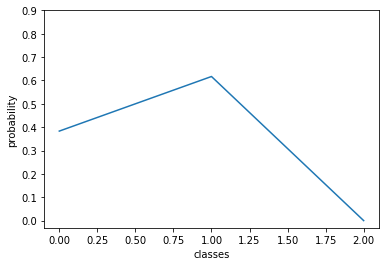

In [43]:
# This competition asks you to analyze the JPG images of galaxies to find automated metrics 
# that reproduce the probability distributions derived from human classifications.  

# For this specific goal, I need to do multi-class classification with soft labels
# (not binary vectors, I am not certain that a galaxy belongs to a specific class)

# Doing some research online, I found out that this task is not considered classification by some people
# but rather a regression problem: is about finding the real value number associated with each class
# abour predicting/fitting a multi-variabl function

# Before attempting this with a NN, I want to simplify the problem by choosing only 3 classes
# (smooth, disk, artifact)
# because the decision tree seems too complicated to deal with (37 outputs)
# so that I can do a classification task with a logistic regression

# In order to change labels from soft to hard I will assume that for each galaxy
# the class with the max probability is the true class of the galaxy

my_classes = []
my_classes.append('1.1 smooth')
my_classes.append('1.2 disk/features')
my_classes.append('1.3 star/artifact')

my_ys = []
for p in y:
    my_y = []
    my_y.append(p[0])
    my_y.append(p[1])
    my_y.append(p[2])
    my_y = np.asarray(my_y, dtype=float)
    my_ys.append(my_y)
    
my_ys = np.asarray(my_ys, dtype=float)

# Let's have a look at the data: 
# are the label distributions very much spread or peak at some classes?

plt.plot(np.arange(3), my_ys[0])
plt.yticks(np.arange(0,1,0.1))
plt.ylabel('probability')
plt.xlabel('classes')
plt.savefig("simplified_soft_labels.pdf")

p_tot = 0   #checking that p sums up to 1
for i in my_ys[0]:
    p_tot += i
print(p_tot)

In [44]:
# from soft to hard labels...

my_ys_hard = []
for distribution in my_ys:
    label = distribution.argmax()
    my_ys_hard.append(label)
    
my_ys_hard = np.asarray(my_ys_hard)

my_train = my_ys_hard[0:800]
my_valid = my_ys_hard[800:900]
my_test = my_ys_hard[900:1000]

print(my_ys_hard.shape)
print(my_train.shape)

(61578,)
(800,)


In [45]:
# Logistic regression:
# Are my 1000 training data points Independently identically distributed? Yes

# Pre-comments: 
# 1. regression is unlikely to work since it is a hihgly non-linear problem!
# 2. 424 is a lot of pixels... one solution could be to crop

In [46]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)
t0 = time.time()

# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
x_train_fl = scaler.fit_transform(x_train_fl)
x_valid_fl = scaler.transform(x_valid_fl)

# apply logistic regressor with 'sag' solver, C is the inverse regularization strength
clf = LogisticRegression(C=1e5,
                         multi_class='multinomial',
                         penalty='l2', solver='sag', tol=0.1)
# fit data
clf.fit(x_train_fl, my_train)
# percentage of nonzero weights
sparsity = np.mean(clf.coef_ == 0) * 100
# compute accuracy
score = clf.score(x_valid_fl, my_valid)

#display run time
run_time = time.time() - t0
print('Example run in %.3f s' % run_time)

print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)

Automatically created module for IPython interactive environment
Example run in 45.545 s
Sparsity with L2 penalty: 0.00%
Test score with L2 penalty: 0.7500


In [47]:
# Comments:
# 1. Logistic Regression took 30s for 800 training points
# and it gives an accuracy of 72%... not bad but probably NN can do better

# 2. Also, I notice that the labels are quite unbalanced: 
# most of the training points are classes 14, 1, 13, 0

# 3. Why sparsity = 0?